In [1]:
import requests
import cassiopeia as cass
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
from cassiopeia.datastores.riotapi.common import APIRequestError

In [3]:
cass.apply_settings({'global': {'version_from_match': 'patch', 'default_region': 'EUW'},
 'plugins': {},
 'pipeline': {'Cache': {},
  'DDragon': {},
  'RiotAPI': {'api_key': 'RIOT_API_KEY'}},
 'logging': {'print_calls': False,
  'print_riot_api_key': False,
  'default': 'WARNING',
  'core': 'WARNING'}})

In [4]:
key = open('../API-keys/riot_dev_key.txt').read()

In [5]:
cass.set_riot_api_key(key)

In [6]:
master_leagues = [(cass.get_master_league('RANKED_SOLO_5x5', region=regions).id, regions) for regions in ['EUW', 'NA', 'KR']]

In [7]:
role_dict = {
    ('MID_LANE', 'SOLO'): 'MIDDLE',
    ('TOP_LANE', 'SOLO'): 'TOP',
    ('JUNGLE', 'NONE'): 'JUNGLE',
    ('BOT_LANE', 'DUO_CARRY'): 'BOTTOM',
    ('BOT_LANE', 'DUO_SUPPORT'): 'SUPPORT'
}

In [8]:
champion_index = list(pd.read_csv('processed_data/chamion_index.csv', index_col=0).values.flatten())

champion_dict = {y:i for i,y in enumerate(champion_index)}

In [62]:
for player in cass.get_challenger_league('RANKED_SOLO_5x5')[:100:10]:
    
    mh = player.summoner.match_history(begin_time=cass.Patch.from_str("10.1", region="EUW").start,
                                      end_time=cass.Patch.from_str("10.15", region='EUW').end,
                                      queues=['CLASH'])
    for match in mh:
        rank_list = []
        for x in match.participants:
            try:
                rank_list.append(x.summoner.ranks[cass.data.Queue('RANKED_SOLO_5x5')].tier.value)
            except:
                rank_list.append('NA')
        print(rank_list)

['CHALLENGER', 'CHALLENGER', 'DIAMOND', 'CHALLENGER', 'DIAMOND', 'MASTER', 'DIAMOND', 'DIAMOND', 'MASTER', 'DIAMOND']
['CHALLENGER', 'CHALLENGER', 'DIAMOND', 'CHALLENGER', 'DIAMOND', 'DIAMOND', 'CHALLENGER', 'DIAMOND', 'GOLD', 'DIAMOND']
['CHALLENGER', 'DIAMOND', 'DIAMOND', 'MASTER', 'GRANDMASTER', 'MASTER', 'CHALLENGER', 'CHALLENGER', 'DIAMOND', 'DIAMOND']
['CHALLENGER', 'CHALLENGER', 'CHALLENGER', 'DIAMOND', 'DIAMOND', 'DIAMOND', 'DIAMOND', 'GRANDMASTER', 'DIAMOND', 'DIAMOND']
['CHALLENGER', 'DIAMOND', 'DIAMOND', 'MASTER', 'DIAMOND', 'DIAMOND', 'CHALLENGER', 'CHALLENGER', 'DIAMOND', 'DIAMOND']
['CHALLENGER', 'DIAMOND', 'MASTER', 'MASTER', 'MASTER', 'GRANDMASTER', 'DIAMOND', 'GRANDMASTER', 'PLATINUM', 'DIAMOND']
['CHALLENGER', 'DIAMOND', 'DIAMOND', 'PLATINUM', 'DIAMOND', 'DIAMOND', 'DIAMOND', 'GRANDMASTER', 'PLATINUM', 'DIAMOND']
['CHALLENGER', 'DIAMOND', 'GRANDMASTER', 'PLATINUM', 'DIAMOND', 'DIAMOND', 'DIAMOND', 'DIAMOND', 'DIAMOND', 'MASTER']
['CHALLENGER', 'GOLD', 'DIAMOND', 'SILV

In [12]:
def multi_league_scrape(league_list, rank=None):
    
    global matches_collected
    matches_collected = []
    
    
    for league_id in tqdm(league_list):
        try:
            league = cass.League(region=league_id[1], id=league_id[0]).entries
        except:
            failed_leagues.append(league_id)
            continue

        df = match_scrape(league)
        
        df.to_csv('high_elo_data/clash_{}_{}_all.csv'.format(rank, league_id[1]), index=False)
        

In [15]:
def scrape_and_save(league_region):
    
    global matches_collected
    matches_collected = []
    
    league = cass.League(region=league_region[1], id=league_region[0]).entries
    
    df = match_scrape(league)
    
    df['champion_ids'] = df.champions.apply(lambda x: [champion_dict[y] for y in x])
    df.to_csv('high_elo_data/comps_master_{}_{}.csv'.format(league_region[1], league_region[0]), index=False)


In [14]:
def match_scrape(cass_league):
    list_df = []
    
    global matches_collected
    matches_collected = []
    
    count = 1
    for player in tqdm(cass_league):
        if count % 75 == 0: #periodic data save
            pd.DataFrame(list_df).to_csv('high_elo_data/master_EUW_{}'.format(count), index=False)
        count += 1
        try:
            try:
                match_history = player.summoner.match_history(begin_time=cass.Patch.from_str("10.1", region="EUW").start,
                                                              end_time=cass.Patch.from_str("10.15", region='EUW').end,
                                                              queues=['CLASH'])

                for match in tqdm(match_history, leave=False):
                    if match.id in matches_collected:
                        continue
                    else:
                        matches_collected.append(match.id)
                    
                    try:
                        try:
                            red_dic = {'team':'red', 'id':match.id, 'win':not match.blue_team.win}
                            red_champ = {}
                            blue_dic = {'team':'blue', 'id':match.id, 'win':match.blue_team.win}
                            blue_champ = {}

                            for participant in match.participants:
                                try:  #check participants are not low ranked
                                    rank = participant.summoner.ranks[cass.data.Queue('RANKED_SOLO_5x5')].tier.value
                                    if rank in ['IRON', 'SILVER', 'GOLD', 'PLATINUM']:
                                        break
                                except:
                                    pass
                                
                                position = role_dict[(participant.lane.value, participant.role.value)]
                                champion = participant.champion.name
                                if participant.side.name == 'blue':
                                    blue_champ.update({position:champion})
                                elif participant.side.name == 'red':
                                    red_champ.update({position:champion})
                            else: # paired with the rank break
                                blue_dic.update({'champions':[blue_champ['TOP'],blue_champ['JUNGLE'],blue_champ['MIDDLE'],blue_champ['BOTTOM'],blue_champ['SUPPORT']]})
                                red_dic.update({'champions':[red_champ['TOP'],red_champ['JUNGLE'],red_champ['MIDDLE'],red_champ['BOTTOM'],red_champ['SUPPORT']]})

                                list_df.append(blue_dic)
                                list_df.append(red_dic)
                        except APIRequestError as e: #allows new key to be used when it expires
                            if '403' in str(e):
                                pd.DataFrame(list_df).to_csv('high_elo_data/master_EUW_{}'.format(count), index=False)
                                cass.set_riot_api_key(input('New key:'))
                    except:
                        continue

            except APIRequestError as e:
                if '403' in str(e):
                    pd.DataFrame(list_df).to_csv('high_elo_data/master_EUW_{}'.format(count), index=False)
                    cass.set_riot_api_key(input('New key:'))

        except:
            pass
        
    return pd.DataFrame(list_df)

In [12]:
df = match_scrape(cass.get_challenger_league('RANKED_SOLO_5x5', region='EUW'))

df.to_csv('high_elo_data/challenger_clash_EUW_all', index=False)

INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service rate limit, backing off for 74 seconds (from headers).


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


In [17]:
df = match_scrape(cass.get_challenger_league('RANKED_SOLO_5x5', region='NA'))

df.to_csv('high_elo_data/clash_challenger_NA_all', index=False)

INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


In [18]:
df = match_scrape(cass.get_challenger_league('RANKED_SOLO_5x5', region='KR'))

df.to_csv('high_elo_data/clash_challenger_KR_all', index=False)

INFO: Unexpected service error (504), backing off for 1.0 seconds.


In [16]:
multi_league_scrape(master_leagues, rank='master')

INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.
INFO: Unexpected service error (504), backing off for 2.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.
INFO: Unexpected service error (429), backing off for 4.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.
INFO: Unexpected service error (429), backing off for 4.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.
INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.
INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.
INFO: Unexpected service error (429), backing off for 4.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.
INFO: Unexpected service error (429), backing off for 2.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (429), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.
INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


INFO: Unexpected service error (504), backing off for 1.0 seconds.


In [36]:
df_champ_expanded = pd.DataFrame.from_records(df.champions.values, columns=['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'SUPPORT'])

In [42]:
df_champ_counts = df_champ_expanded.apply(lambda x :x.value_counts())

,TOP,JUNGLE,MIDDLE,BOTTOM,SUPPORT
Aatrox,321.0,10.0,47.0,1.0,NaN
Ahri,12.0,NaN,238.0,6.0,7.0
Akali,109.0,NaN,87.0,NaN,NaN
Alistar,3.0,NaN,NaN,NaN,91.0
Amumu,NaN,82.0,1.0,NaN,NaN
...,...,...,...,...,...
Zed,25.0,3.0,352.0,2.0,NaN
Ziggs,4.0,NaN,96.0,73.0,2.0
Zilean,4.0,NaN,59.0,4.0,127.0
Zoe,3.0,1.0,213.0,3.0,9.0


In [46]:
comp_distribution = df.champions.value_counts()

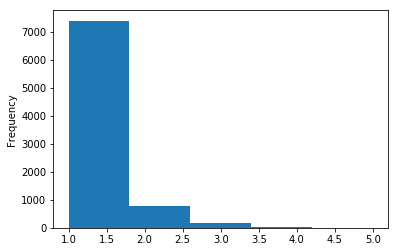

In [49]:
comp_distribution.plot.hist(bins=5)

In [43]:
df_champ_expanded.to_csv('expanded_array.csv', index=False)

In [28]:
df['champion_ids'] = df.champions.apply(lambda x: [champion_dict[y] for y in x])

In [19]:
import os

In [26]:
clash_list = [pd.read_csv('high_elo_data/'+path) for path in [x for x in os.listdir('./high_elo_data') if 'clash' in x]]

clash_df = pd.concat(clash_list)

lang = pd.DataFrame([x.name for x in cass.get_champions(region='KR')])

lang['riot_id'] = [x.id for x in cass.get_champions(region='KR')]

lang = lang[lang.riot_id != 777].reset_index(drop=True).copy()

korean_index = {k:[x.name for x in cass.get_champions(region='EUW')][v] for v,k in enumerate(lang[0])}

import ast

clash_df.champions = clash_df.champions.apply(lambda x: ast.literal_eval(x))

clash_df.champions = clash_df.champions.apply(lambda x: [korean_index[y] if y in korean_index.keys() else y for y in x])

clash_df.to_csv('processed_data/clash_df.csv', index=False)